# Multi-Class Classification
이 연습에서는 로지스틱 회귀를 사용하여 손으로 쓴 숫자 (0-9)를 인식합니다. 우리는 실습 2 에서 쓴 로지스틱 회귀 분석의 구현을 확장하여 하나-대-전체 (one-vs-all) 분류에 적용 할 것입니다. 데이터 세트를 로드하여 시작합시다. 이것은 MATLAB의 기본 형식이므로 Python으로 로드하려면 SciPy 유틸리티를 사용해야합니다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
%matplotlib inline

data = loadmat('ex3data1.mat')
data

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


{'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [2]:
data['X'].shape, data['y'].shape

((5000, 400), (5000, 1))

좋습니다. 이제 데이터가 로드 되었습니다. 이미지는 행렬 X 에 400 차원 벡터로 표현됩니다 (5,000개 중의 하나로). 400 개의 "특징(feature)"는 원본 20 x 20 이미지의 각 픽셀에 대한 그레이 스케일 강도입니다. 클래스 레이블은 이미지에 있는 숫자를 나타내는 숫자 클래스로 벡터 y에 있습니다. (여기에서, 인덱싱할 때 혼란을 피하기 위해서 "0"을 "10" 으로 표시하였습니다.)
 
트레이닝 세트의 서브 세트를 시각화하여 시작할 것입니다. 아래의 코드는 X 에서 40 개의 행을 임의로 선택하여 해당 행을 20x20 픽셀 회색조 이미지로 매핑하고 이미지를 함께 표시합니다. 이 단계를 실행하면 그림과 같은 이미지가 나타납니다.

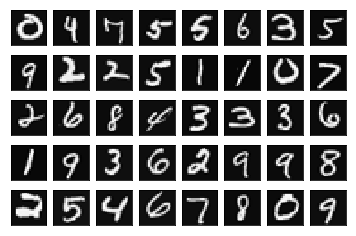

In [3]:
select = np.random.randint(5000, size=40)

fig, axs = plt.subplots(5,8,subplot_kw={'xticks': [], 'yticks': []})

for i in np.arange(5):
    for j in np.arange(8):
        one = np.matrix(data['X'])[select[i*8+j],:].reshape(20,20)
        axs[i][j].imshow(one.T, cmap='gray')
    
plt.show()

### 로지스틱 회귀 백터화
 
첫 번째 작업은 로지스틱 회귀 구현을 완전히 벡터화되도록 수정하는 것입니다 (즉, "for"루프 없음). 이는 벡터화 된 코드가 짧고 간결한 것 외에도 선형 대수 최적화를 이용할 수 있고 일반적으로 반복 코드보다 훨씬 빠르기 때문입니다. 그러나 연습 2 에서 비용 함수 구현을 보면 이미 벡터화되어 있습니다! 그래서 우리는 여기서 같은 구현을 재사용 할 수 있습니다. 마지막으로 정규화 된 버전으로 곧바로 건너 뜁니다.

### 비용함수 벡터화
비용 함수의 벡터화 된 버전을 작성 시작하겠습니다. (비정규화 된) 로지스틱 회귀 분석에서 비용 함수는 다음과 같다.

$$ J(\theta) = {1\over m} \sum_{i=1}^m [-y^{(i)} \log(h_\theta(x^{(i)})) - (1 - y^{(i)}) \log(1-h_\theta(x^{(i)}))] $$

합산되는 각 요소의 계산을 위해서는 모든 자료 $i$에 대한 $h_\theta (x^{(i)})$ 를 구해야하며, 여기에서 $h_\theta (x^{(i)})= g(\theta^T x^{(i)})$ 이며, $g(z) = { 1 / (1 + e^{-z} )}$ 는 시그모이드 함수이다.



우리는 행렬 곱셈을 사용하여 모든 훈련 자료에 대해 이를 빠르게 계산할 수 있음을 알 수 있다.
$X$ 와 $\theta$ 를 다음과 같이 정의하자.
 
$$ X = \begin{bmatrix}
 (x^{(1)})^T  \\
 (x^{(2)})^T  \\
\vdots \\
 (x^{(m)})^T  \\
\end{bmatrix}
$$ 


and         
$$   \theta = 
     \begin{bmatrix}
         \theta_0 \\
         \theta_1 \\
         \vdots\\
         \theta_n \\
\end{bmatrix}
$$

그러면, 행렬곱 $X \theta$를 계산하여, 다음을 얻게 된다.
  
$$ X \theta = \begin{bmatrix}
(x^{(1)})^T \theta \\
(x^{(2)})^T \theta \\
\vdots \\
(x^{(m)})^T \theta \\
\end{bmatrix}
$$
or
$$ 
 X \theta = \begin{bmatrix}
         \theta^T (x^{(1)}) \\
         \theta^T (x^{(2)}) \\
         \vdots \\
         \theta^T (x^{(m)}) \\
         \end{bmatrix}
$$
         
마지막 등식에서 우리는 $a$와 $b$가 벡터라면 $a^T b = b^T a$라는 사실을 사용했다.

이렇게 하면 한 줄의 코드에서 모든 훈련자료 $i$에 대한 $θ^T x^{(i)}$의 곱을 계산할 수 있습니다. 여러분의 임무는 정규화를 포함한 비용 함수를 cost() 파일에 작성하는 것입니다.

구현은 앞의 $θ^T x^{(i)}$ 를 계산하기 위해 앞서 제시한 전략을 사용해야 합니다. 나머지 부분에는 벡터화된 접근 방식을 사용해야 합니다.
비용 함수 cost()의 완전히 벡터화 된 버전에는 루프가 없어야합니다.

In [5]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def cost(theta, X, y, a_lambda):
    # Problem(1) - 10 points ==============================
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    first  = np.multiply(     -y, np.log(    sigmoid(X * theta.T)))
    second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    regular = (a_lambda / 2 * len(X)) * np.sum(np.power(theta[:,1:theta.shape[1]], 2))
    J = np.sum(first - second) / (len(X)) + regular
    # =====================================================
    return J

X = np.insert(data['X'], 0, values=np.ones(5000), axis=1)
y = data['y']
theta = np.zeros(401)
a_lambda = 0
cost(theta, X, y, a_lambda)

-17.051420641774662

### 그라디언트의 벡터화

비용의 기울기는 $\theta$ 와 동일한 길이의 벡터이며, 여기서 j 번째 요소 (j = 0,1, ..., n의 경우)는 다음과 같이 정의됩니다.

$$ {\partial J(\theta) \over \partial \theta_j } = {1\over m} \sum_{i=1}^m ((h_\theta(x^{(i)})-y^{(i)}) x_j^{(i)})$$

이 그 레디언트는 선형 회귀 기울기와 동일하게 보이지만, 선형 및 회귀 분석에서는 $h_\theta (x)$ 의 정의가 다르기 때문에 수식이 실제로는 다릅니다.
이전 연습에서 그라디언트를 계산하는 함수를 이미 정의 했었습니다. 이 경우 업데이트 단계에서 제거해야하는 "for"루프가 있습니다. 다음은 참조용 원본 코드입니다.

In [6]:
def gradient_with_loop(theta, X, y, reg_lambda):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    parameters = int(theta.ravel().shape[1])
    grad = np.zeros(parameters)
    
    error = sigmoid(X * theta.T) - y
    
    for i in range(parameters):
        term = np.multiply(error, X[:,i])
        
        if (i == 0):
            grad[i] = np.sum(term) / len(X)
        else:
            grad[i] = (np.sum(term) / len(X)) + ((reg_lambda / len(X)) * theta[:,i])
    
    return grad

gradient_with_loop(theta, X, y, a_lambda)[:10]

array([-5.00000000e+00,  0.00000000e+00,  0.00000000e+00, -7.74530186e-08,
        3.19876600e-06,  1.89536237e-05, -7.06376094e-04, -8.97395355e-04,
       -3.72741263e-04, -1.10787541e-04])

우리의 새 버전에서는 "for"루프를 제거하고 선형 대수를 사용하여 각 매개 변수에 대한 그래디언트를 계산할 것입니다 (단절된 매개 변수는 정규화되지 않으므로 별도로 계산됩니다). 

또한 데이터 구조를 NumPy 행렬 (이 연습에서 대부분 사용한 적이 있는)으로 변환하고 있습니다. 이는 행렬이 자동으로 행렬 연산 규칙 대 배열의 기본값 인 요소 별 연산을 따르므로 코드를 배열을 사용하는 것보다 Matlab (또는 Octave)와 유사하게 보이도록 하기 위해 수행됩니다. 매트릭스 클래스를 사용하는 것과 사용하지 말아야 하는 논란이 있긴 하지만, 이 예제에서는 이를 사용하고 있습니다.

데이터 집합에 대한 이 연산을 벡터화하기 위해 모든 작업을 $\theta_j$에 대한 편미분으로 작성해 본다.

$$ \begin{bmatrix}
{\partial J \over \partial \theta_0} \\
\partial J \over \partial \theta_1 \\
\partial J \over \partial \theta_2 \\
\vdots\\
\partial J \over \partial \theta_n
\end{bmatrix} 
= {1 \over m}  
\begin{bmatrix}
\sum_{i=1}^m((h_\theta (x^{(i)}) - y^{(i)})x_0^{(i)}) \\
\sum_{i=1}^m((h_\theta (x^{(i)}) - y^{(i)})x_1^{(i)}) \\
\sum_{i=1}^m((h_\theta (x^{(i)}) - y^{(i)})x_2^{(i)}) \\
\vdots\\
\sum_{i=1}^m((h_\theta (x^{(i)}) - y^{(i)})x_m^{(i)}) 
\end{bmatrix}
= {1 \over m} 
         \sum_{i=1}^m ((h_\theta (x^{(i)}) - y^{(i)})x^{(i)})
         = {1 \over m} 
         X^T(h_\theta (x) - y)
$$

여기에서 

$$
h_\theta (x) - y = 
\begin{bmatrix}
h_\theta (x^{(0)}) - y^{(0)} \\
h_\theta (x^{(1)}) - y^{(1)} \\
\vdots\\
h_\theta (x^{(m)}) - y^{(m)} 
\end{bmatrix}
$$

이 때, $(h_\theta (x^{(i)}) - y^{(i)})$는 스칼라(하나의 숫자)이지만, $x^{(i)}$ 는 벡터임의 주의 하시오. 위의 유도과정의 마지막 부분을 이해하기 위해서, $\beta_i =(h_\theta (x^{(i)}) - y^{(i)})$라 하고, 다음을 살펴봅시다.

$$
\sum_i \beta_i x^{(i)} = [ x^{(1)} x^{(2)} \cdots  x^{(m)} ]
\begin{bmatrix}
\beta_1 \\
\beta_2 \\
\vdots\\
\beta_m
\end{bmatrix}
= X^T \beta
$$ 

위의 표현식을 사용하면 루프없이 모든 편미분을 계산할 수 있습니다. 선형 대수에 익숙하다면 위의 행렬 곱셈을 통해 벡터화 된 버전이 동일한 계산을 수행한다는 사실을 확신 할 수 있습니다. 올바른 벡터화 된 그라디언트를 계산하려면 위의 식을 구현해야 합니다. 완료되면 그라디언트를 구현하여 함수를 완료하십시오.

In [7]:
def gradient(theta, X, y, reg_lambda):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    parameters = int(theta.ravel().shape[1])
    
    # Problem (2) - 10 points =========================================
    error = sigmoid(X * theta.T) - y
    
    grad = ((X.T * error) / len(X)).T + ((reg_lambda / len(X)) * theta)
    
    # intercept gradient is not regularized
    grad[0, 0] = np.sum(np.multiply(error, X[:,0])) / len(X)
    # =================================================================
    return np.array(grad).ravel()

gradient(theta, X, y, a_lambda)[:10]

array([-5.00000000e+00,  0.00000000e+00,  0.00000000e+00, -7.74530186e-08,
        3.19876600e-06,  1.89536237e-05, -7.06376094e-04, -8.97395355e-04,
       -3.72741263e-04, -1.10787541e-04])

### 하나-대-전체(one-vs-all) 분류
이제 비용 및 그레디언트 함수를 정의 했으므로 이제 분류자를 작성해야합니다. 이 작업에는 10 가지 클래스가 있으며 로지스틱 회귀는 한 번에 2 개 클래스 사이에서만 구분할 수 있으므로 다중 클래스 시나리오를 처리하는 전략이 필요합니다. 이 연습에서는 하나-대-전체 분류 접근법을 구현하는 임무를 띠고 있습니다. k 개의 다른 클래스가있는 레이블은 k 개의 분류자를 생성하며, 각각은 "클래스 i"와 "클래스 i가 아닌"(즉, i 이외의 모든 클래스들) 것을 결정합니다.. 우리는 분류자 트레이닝을 10 개의 분류자 각각에 대한 최종 가중치를 계산하는 하나의 함수로 랩핑하고 k x (n + 1) 배열로 가중치를 반환합니다. 여기서 n은 매개 변수의 수입니다.

In [8]:
from scipy.optimize import minimize

def one_vs_all(X, y, num_labels, reg_lambda):
    rows = X.shape[0]
    params = X.shape[1]
    
    # k X (n + 1) array for the parameters of each of the k classifiers
    all_theta = np.zeros((num_labels, params + 1))
    
    # insert a column of ones at the beginning for the intercept term
    X = np.insert(X, 0, values=np.ones(rows), axis=1)
    
    # Problem (3) - 10 points ==========================================
    
    # labels are 1-indexed instead of 0-indexed
    for i in range(1, num_labels + 1):
        theta = np.zeros(params + 1)
        y_i = np.array([1 if label == i else 0 for label in y])
        y_i = np.reshape(y_i, (rows, 1))
    # ==================================================================
    
        # minimize the objective function
        #fmin = minimize(fun=cost, x0=theta, args=(X, y_i, reg_lambda), method='TNC', jac=gradient, options={'maxiter':100})
        fmin = minimize(fun=cost, x0=theta, args=(X, y_i, reg_lambda), method='TNC', jac=gradient)
        all_theta[i-1,:] = fmin.x
    
    return all_theta

여기서 주목해야 할 몇 가지 사항은 ... 먼저, 절편 용어를 설명하기 위해 $\theta$에 추가 매개 변수를 추가합니다 (훈련 데이터에 대한 열의 항목과 함께). 둘째, y를 클래스 레이블에서 각 분류자 (클래스 i 또는 클래스 i가 아닌 클래스)의 이진 값으로 변환합니다. 마지막으로 우리는 SciPy의 새로운 최적화 API를 사용하여 각 분류자의 비용 함수를 최소화합니다. API는 목적 함수, 초기 매개 변수 집합, 최적화 방법 및 지정된 경우 jacobian (그라디언트) 함수를 사용합니다. 그런 다음 최적화 루틴에서 찾은 매개 변수가 매개 변수 배열에 지정됩니다.

벡터화 된 코드를 구현하는 것이 더 어려운 부분 중 하나는 행렬 상호 작용을 모두 올바르게 작성하는 것입니다. 그래서 내가 작업하고 있는 배열 / 행렬의 모양을 보고 몇 가지 온전성 검사를 하는 것이 유용하다는 것을 알았습니다. 재치있는. 위의 함수에서 사용 된 데이터 구조 중 일부를 살펴 보겠습니다.

In [9]:
rows = data['X'].shape[0]
params = data['X'].shape[1]

all_theta = np.zeros((10, params + 1))

X = np.insert(data['X'], 0, values=np.ones(rows), axis=1)

theta = np.zeros(params + 1)

y_0 = np.array([1 if label == 0 else 0 for label in data['y']])
y_0 = np.reshape(y_0, (rows, 1))

X.shape, y_0.shape, theta.shape, all_theta.shape

((5000, 401), (5000, 1), (401,), (10, 401))

이것들은 모두 의미가있는 것처럼 보입니다. theta는 1 차원 배열이므로 기울임 꼴을 계산하는 코드에서 행렬로 변환되면 (1 X 401) 행렬이 됩니다. y의 클래스 레이블을 확인하여 예상 한 것처럼 보이게 하십시오.

In [10]:
np.unique(data['y'])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

우리의 트레이닝 기능이 실제로 작동하는지 확인하고 더 나아 가기 전에 합리적인 결과를 얻으십시오.

In [10]:
all_theta = one_vs_all(data['X'], data['y'], 10, 2)
all_theta

array([[-1.85211019e-05,  0.00000000e+00,  0.00000000e+00, ...,
        -1.12381377e-10,  1.15966432e-11,  0.00000000e+00],
       [-4.48069899e-05,  0.00000000e+00,  0.00000000e+00, ...,
         3.62837674e-09, -3.09791087e-10,  0.00000000e+00],
       [-4.19742663e-05,  0.00000000e+00,  0.00000000e+00, ...,
        -3.80683910e-10,  2.32378596e-11,  0.00000000e+00],
       ...,
       [-3.50272719e-05,  0.00000000e+00,  0.00000000e+00, ...,
        -3.45733847e-10,  2.14468865e-11,  0.00000000e+00],
       [-3.82583048e-05,  0.00000000e+00,  0.00000000e+00, ...,
        -4.04571890e-10,  2.65429364e-11,  0.00000000e+00],
       [-3.31728638e-05,  0.00000000e+00,  0.00000000e+00, ...,
        -1.74719954e-09,  5.67771659e-11,  0.00000000e+00]])

이제 최종 단계에 대한 준비가 완료되었습니다. 훈련 된 분류 기준을 사용하여 각 이미지의 라벨을 예측합니다. 이 단계에서는 각 클래스의 클래스 확률을 벡터화 된 코드를 사용하여 각 교육 인스턴스에 대해 계산하고 가장 높은 확률을 가진 클래스로 출력 클래스 레이블을 지정합니다.

In [11]:
def predict_all(X, all_theta):
    rows = X.shape[0]
    params = X.shape[1]
    num_labels = all_theta.shape[0]
    
    # same as before, insert ones to match the shape
    X = np.insert(X, 0, values=np.ones(rows), axis=1)
    
    # convert to matrices
    X = np.matrix(X)
    all_theta = np.matrix(all_theta)
    
    # compute the class probability for each class on each training instance
    h = sigmoid(X * all_theta.T)
    
    # create array of the index with the maximum probability
    h_argmax = np.argmax(h, axis=1)
    
    # because our array was zero-indexed we need to add one for the true label prediction
    h_argmax = h_argmax + 1
    
    return h_argmax

이제 우리는 predict_all 함수를 사용하여 각 인스턴스에 대한 클래스 예측을 생성하고 분류 자의 작동 방식을 확인할 수 있습니다.

In [12]:
y_pred = predict_all(data['X'], all_theta)
correct = [1 if a == b else 0 for (a, b) in zip(y_pred, data['y'])]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print('accuracy = {0}%'.format(accuracy * 100))

accuracy = 74.6%


거의 75 %가 나쁘지 않습니다!  다음 연습에서는 전방향전파(feed-forward) 신경망을 처음부터 구현하는 방법을 살펴 보겠습니다.

## 신경망

이 연습의 이전 부분에서는 다중 클래스 로지스틱 회귀를 구현하여 손으로 쓴 숫자를 인식했습니다. 그러나 로지스틱 회귀는 단지 선형 분류이기 때문에 더 복잡한 가설을 세울 수 없다.

이번에는 이전과 동일한 교육 세트를 사용하여 손으로 쓴 숫자를 인식하는 신경망을 구현합니다. 신경망은 비선형 가설을 형성하는 복잡한 모델을 나타낼 수 있습니다. 이번에는 이미 훈련된 신경망의 매개 변수를 사용하게 될 것입니다. 목표는 예측을 하는데 가중치를 사용하는 피드 포워드 전달 알고리즘을 구현하는 것입니다. 다음 연습에서는 신경망 매개 변수를 학습하기 위한 역전파 알고리즘을 작성합니다.

### 모델 표현

우리의 신경 네트워크는 아래의 그림 2에 나와 있습니다. 입력 층, 은닉 층 및 출력 층의 3개 층이 있습니다. 입력 값은 숫자 이미지의 픽셀 값입니다. 이미지의 크기가 20 × 20 이므로 400개의 입력 층 노드를 제공합니다 (항상 +1을 출력하는 추가 바이어스 노드 제외). 이전과 마찬가지로, 학습 데이터는 변수 $X$와 $y$에 로드됩니다.  

<img src="fig2.png" width=350>

이미 우리가 훈련한 네트워크 매개 변수 집합 ($\Theta^{(1)}, \Theta^{(2)}$)이 제공되었습니다. 이것들은 ex3weights.mat에 저장되어 있으며, Theta1과 Theta2로 읽혀집니다. 매개 변수에는 두 번째 층에 25 노드과 10 개의 출력 노드 (숫자 10개 클래스에 해당)이 있는 신경망에 맞는 크기를 갖습니다.

In [13]:
weights = loadmat('ex3weights.mat')

In [14]:
weights['Theta1'].shape, weights['Theta2'].shape

((25, 401), (10, 26))

### 전방향 전파 및 예측

이제 신경망에 대한 전방향(feed-forward) 전파를 구현합니다. 신경망의 예측을 반환하려면 forward_propagatge 코드를 완료해야합니다. 이는 $h_\theta (x^{(i)})$를 계산하는 전방향 계산을 구현해야 합니다. 모든 예제 i와 관련된 예측을 반환합니다. one-vs-all 분류 전략과 유사하게, 신경망으로부터의 예측은 가장 큰 출력 $(h_\theta (x))_k$ 를 갖는 라벨이 될 것이다.

**구현시 참고 사항**: 행렬 X는 훈련자료를 행에 포함합니다. 예측 코드를 완료하려면 1의 열을 행렬에 추가해야 합니다. 행렬 Theta1과 Theta2는 행에 있는 각 단위에 대한 매개 변수를 포함합니다. 특히 Theta1의 첫 번째 행은 두 번째 계층의 첫 번째 숨겨진 유닛에 해당합니다. 

In [15]:
X = np.matrix(data['X'])
y = np.matrix(data['y'])
theta1 = np.matrix(weights['Theta1'])
theta2 = np.matrix(weights['Theta2'])

def forward_propagate(X, theta1, theta2):
    # Problem (4)  --- 10 Points ================================
    m = X.shape[0]
    a1 = np.insert(X, 0, values=np.ones(m), axis=1)
    z2 = a1 * theta1.T
    a2 = np.insert(sigmoid(z2), 0, values=np.ones(m), axis=1)
    z3 = a2 * theta2.T
    h = sigmoid(z3) 
    # ===========================================================
    return h

h = forward_propagate(X, theta1, theta2)
y_pred = np.array(np.argmax(h, axis=1) + 1)
correct = [1 if a == b else 0 for (a, b) in zip(y_pred, y)]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print('accuracy =', accuracy * 100, '%')

accuracy = 97.52 %
